In [1]:
import importlib
import GNN_module.scripts as scripts #only used for on the fly reloads
import torch
import copy
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

from torch_geometric.nn.models import GAT, GCN
from sklearn.model_selection import ParameterGrid
import numpy as np

from GNN_module.scripts import *
import torch.nn.functional as F
from carbontracker.tracker import CarbonTracker


In [52]:
#Run this to reload the scripts without restarting the kernel
importlib.reload(scripts)
from GNN_module.scripts import *

# IMPORTANT: write requirements file and readme after work is done

# Datasets

In [34]:
dataset_cora = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
dataset_citeseer = Planetoid(root='data/Planetoid', name='CiteSeer', transform=NormalizeFeatures())
dataset_pubmed = Planetoid(root='data/Planetoid', name='Pubmed', transform=NormalizeFeatures())

In [35]:
dataset = dataset_cora
data = dataset[0]  # Get the first graph object.
num_epochs = 500
dataset_statistics(dataset)

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


# Model initialising

In [4]:
gat = GAT(in_channels=dataset.num_features, hidden_channels=8, num_layers=2, out_channels=dataset.num_classes, heads=8, dropout=0.6, act=F.elu)
optimizer_gat = torch.optim.Adam(gat.parameters(), lr=0.005, weight_decay=5e-4)
gatv2 = GAT(v2 = True, in_channels=dataset.num_features, hidden_channels=8, num_layers=2, out_channels=dataset.num_classes, heads=8, dropout=0.6, act=F.elu)
optimizer_gatv2 = torch.optim.Adam(gatv2.parameters(), lr=0.005, weight_decay=5e-4)
gcn = GCN(in_channels=dataset.num_features, hidden_channels=8, out_channels=dataset.num_classes, num_layers=2, dropout=0.6)
optimizer_gcn = torch.optim.Adam(gcn.parameters(), lr=0.01, weight_decay=5e-4)

criterion = torch.nn.CrossEntropyLoss()

In [5]:
num_params_gat = count_trainable_parameters(gat)
num_params_gatv2 = count_trainable_parameters(gatv2)
num_params_gcn = count_trainable_parameters(gcn)

print(f'Number of trainable parameters in GAT: {num_params_gat}')
print(f'Number of trainable parameters in GATv2: {num_params_gatv2}')
print(f'Number of trainable parameters in GCN: {num_params_gcn}')

Number of trainable parameters in GAT: 12055
Number of trainable parameters in GATv2: 24031
Number of trainable parameters in GCN: 11535


# Training

In [6]:
loss_list_gat = train_model(num_epochs, gat, data, optimizer_gat, criterion)
loss_list_gatv2 = train_model(num_epochs, gatv2, data, optimizer_gatv2, criterion)
loss_list_gcn = train_model(num_epochs, gcn, data, optimizer_gcn, criterion)

Training model...

Training model...0.7843562960624695

Training model...0.6719067692756653



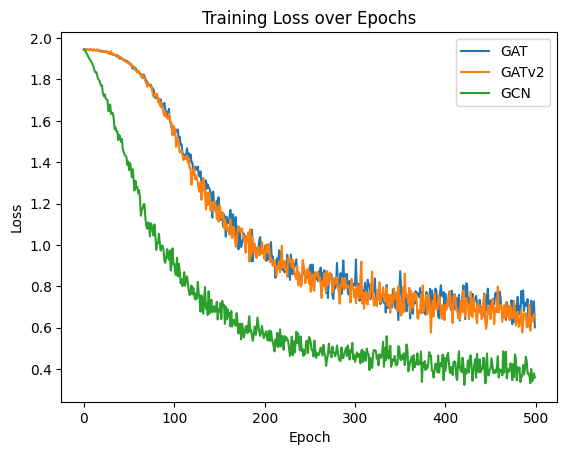

In [53]:
plt.plot(loss_list_gat[:500], label='GAT')
plt.plot(loss_list_gatv2[:500], label='GATv2')
plt.plot(loss_list_gcn[:500], label='GCN')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.show()

In [7]:
test_model(data.test_mask, gat, dataset), test_model(data.test_mask, gatv2, dataset), test_model(data.test_mask, gcn, dataset)

(0.574, 0.482, 0.769)

# Research ideas





## Robustness of GATs to Adversarial Attacks
### Research Question: 
How robust are Graph Attention Networks to adversarial attacks compared to other GNN architectures?
### Hypothesis:
 GATs, due to their ability to focus on important nodes via attention, are more robust against adversarial attacks than non-attention-based GNNs like Graph Convolutional Networks (GCNs).
### Novelty:
You can simulate simple adversarial attacks (e.g., perturbing node features or edges) and compare the robustness of GATs vs. GCNs or other GNN architectures.



## Transfer Learning with Graph Attention Networks
### Research Question:
Can GATs trained on one type of graph (e.g., a citation network) be effectively transferred to another type (e.g., a social network) using transfer learning?
### Hypothesis:
GATs are more effective for transfer learning between graphs of similar structures (e.g., citation networks to co-authorship networks) compared to graphs with significantly different structures (e.g., citation to biological networks).
### Novelty:
Explore transfer learning in GNNs, specifically GATs, which is less explored. You can train on one graph type, fine-tune on another, and measure performance gains.


# Hyperparameter sweep

In [94]:
#Note that the hidden channels is asa multiplum of number of heads
hyperparameters_gat = {'hidden_channels': [2, 4, 8, 16], 'num_layers': [1, 2, 4, 8], 'heads': [1, 2, 4, 8, 16], 'dropout': [0.0, 0.2, 0.4, 0.6, 0.8]}

In [103]:

sweep = hp_sweep(1, data.val_mask, dataset, hyperparameters_gat, criterion, 'sweep1epoch.pkl')

In [97]:
idx_best = 0
best_acc = 0
for i, test in enumerate(sweep):
    acc = test['test_accuracy']
    if acc > best_acc:
        best_acc = acc
        idx_best = i

In [99]:
sweep[idx_best]['hyperparameters']

{'dropout': 0.2, 'heads': 16, 'hidden_channels': 16, 'num_layers': 8}

# Robustness

We can test robustness to disruptions in the data in a number of ways:

- Adding feature noise (Gaussian noise to each feature or noise acroos entire dataset)
- Adding non existing edges
- Removing edges

## Feature noise

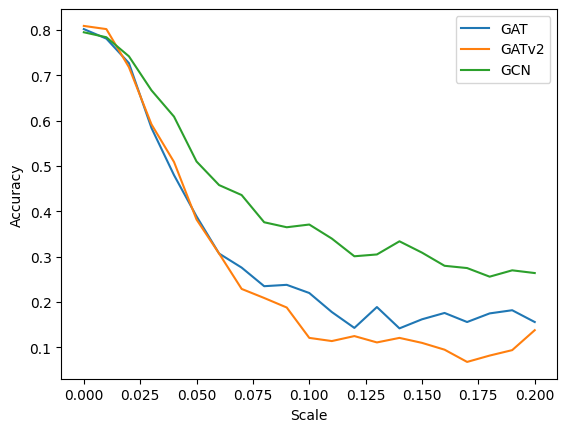

In [53]:
scale, acc_gat = test_feature_noise_robustness(gat, data)
_, acc_gatv2 = test_feature_noise_robustness(gatv2, data)
_, acc_gcn = test_feature_noise_robustness(gcn, data)

plt.plot(scale, acc_gat, label='GAT')
plt.plot(scale, acc_gatv2, label='GATv2')
plt.plot(scale, acc_gcn, label='GCN')# Not comparable, because we haven't done hyperparameter tuning
plt.legend()
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.show()

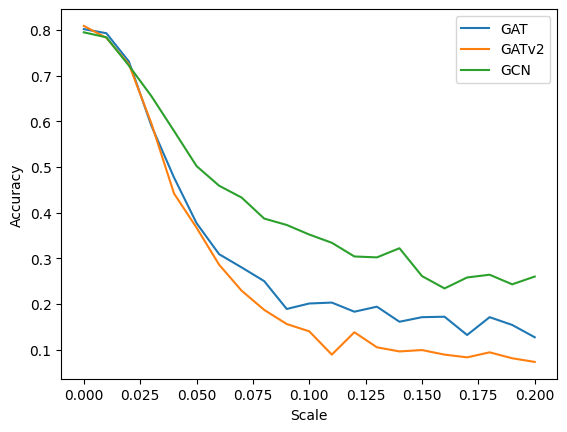

In [30]:
scale, acc_gat = test_feature_noise_robustness(gat, data, global_noise=False)
_, acc_gatv2 = test_feature_noise_robustness(gatv2, data, global_noise=False)
_, acc_gcn = test_feature_noise_robustness(gcn, data, global_noise=False)

plt.plot(scale, acc_gat, label='GAT')
plt.plot(scale, acc_gatv2, label='GATv2')
plt.plot(scale, acc_gcn, label='GCN')# Not comparable, because we haven't done hyperparameter tuning
plt.legend()
plt.xlabel('Scale')
plt.ylabel('Accuracy')
plt.show()

In [36]:
tests = []
num_tests = 10
scale = None
for i in range(num_tests):
    scale, acc = test_feature_noise_robustness(gat, data, global_noise=False)
    tests.append(acc)

In [62]:
def do_n_tests(test_fun, model, data, n, global_noise=True):
    tests = []
    scale = None
    for i in range(n):
        scale, acc = test_fun(model, data, global_noise)
        tests.append(acc)
    assert scale is not None
    return np.array(scale), np.array(tests)

In [63]:

scale, tests = do_n_tests(test_feature_noise_robustness, gat, data, 10, global_noise=False)


In [61]:
len(np.array(tests).shape)

2

In [68]:
def plot_with_std(scale, tests, more_plots_coming=False):
    mean_data = np.mean(tests, axis=0)
    std_data = np.std(tests, axis=0)

    plt.plot(scale, mean_data, label='Mean Accuracy')#, color='g')

    # Visualize the variance using a shaded region
    plt.fill_between(scale, mean_data - std_data, mean_data + std_data, alpha=0.2, label='std')
    if not(more_plots_coming):
        # Add labels and legend
        plt.xlabel('Noise scale')
        plt.ylabel('Accuracy')
        plt.title('Mean and Variance of GAT Accuracy with Feature Noise')
        plt.legend()
        plt.show()


In [70]:
def plot_n_tests(tests, scale):
    if len(tests.shape) == 1:
        plt.plot(scale, tests)
    elif len(tests.shape) == 2:
        plot_with_std(scale, tests)
    else:
        for i, test in enumerate(tests):
            plot_with_std(scale, test, i < len(tests) - 1)

    


In [71]:
tests1 = np.array([tests, tests+0.1])

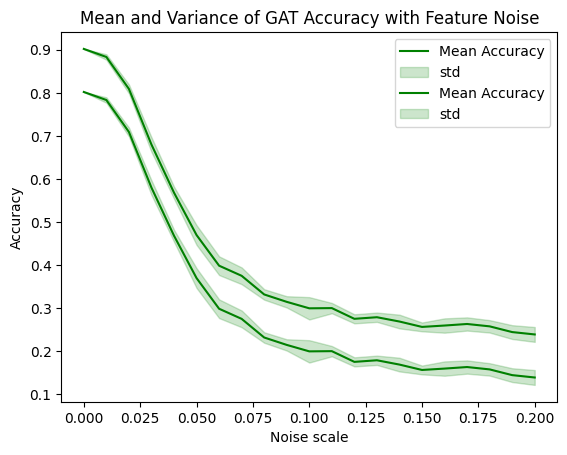

In [72]:
plot_n_tests(tests1, scale)

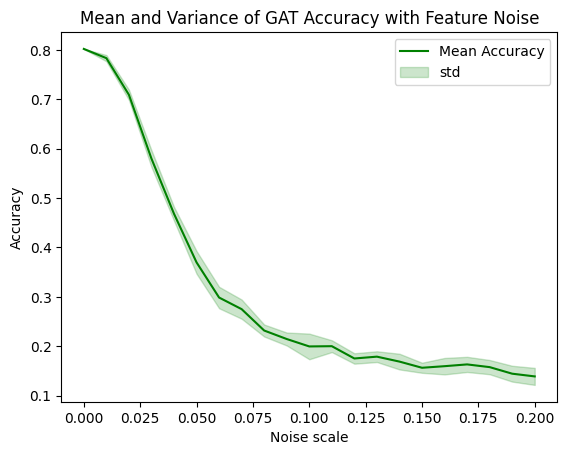

In [64]:
# Calculate the mean and standard deviation
mean_data = np.mean(tests, axis=0)
std_data = np.std(tests, axis=0)

plt.plot(scale, mean_data, label='Mean Accuracy', color='g')

# Visualize the variance using a shaded region
plt.fill_between(scale, mean_data - std_data, mean_data + std_data, color='g', alpha=0.2, label='std')

# Add labels and legend
plt.xlabel('Noise scale')
plt.ylabel('Accuracy')
plt.title('Mean and Variance of GAT Accuracy with Feature Noise')
plt.legend()
plt.show()

In [23]:


# Set the length of the arrays
n = 100

# Generate random data for 5 experiments
data = np.random.rand(5, n)

# Calculate the mean and standard deviation
mean_data = np.mean(data, axis=0)
std_data = np.std(data, axis=0)

# Plot the mean data
plt.plot(mean_data, label='Mean')

# Visualize the variance using a shaded region
plt.fill_between(range(n), mean_data - std_data, mean_data + std_data, color='b', alpha=0.2, label='Variance')

# Add labels and legend
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Mean and Variance of Experiment Data')
plt.legend()
plt.show()

0.010004587